In [1]:
import gym
import copy
import numpy as np
import time
import sys 
import torch
sys.path.append("MCTS") 
from monteCarlo import MCTree
import tools
from tools import get_args, registration_envs
from model import DRL_GAT
from network import nmodel

pretrained_models/PCT_setting1.pt
Loading pre-train upper model pretrained_models/PCT_setting1.pt
Pre-train model loaded! pretrained_models/PCT_setting1.pt


In [2]:
registration_envs()
args = get_args()
env = gym.make(args.id,
               setting = args.setting,
               item_set = args.item_size_set,
               container_size=args.container_size,
               internal_node_holder = args.internal_node_holder,
               leaf_node_holder = args.leaf_node_holder,
               LNES = args.lnes,
               shuffle=args.shuffle,
               sample_from_distribution=args.sample_from_distribution,
               sample_left_bound=args.sample_left_bound,
               sample_right_bound=args.sample_right_bound
               )
if args.no_cuda:
        device = torch.device('cpu')
else:
    device = torch.device('cuda', args.device)
    torch.cuda.set_device(args.device)

[(1, 1, 1), (1, 1, 2), (1, 1, 3), (1, 1, 4), (1, 1, 5), (1, 2, 1), (1, 2, 2), (1, 2, 3), (1, 2, 4), (1, 2, 5), (1, 3, 1), (1, 3, 2), (1, 3, 3), (1, 3, 4), (1, 3, 5), (1, 4, 1), (1, 4, 2), (1, 4, 3), (1, 4, 4), (1, 4, 5), (1, 5, 1), (1, 5, 2), (1, 5, 3), (1, 5, 4), (1, 5, 5), (2, 1, 1), (2, 1, 2), (2, 1, 3), (2, 1, 4), (2, 1, 5), (2, 2, 1), (2, 2, 2), (2, 2, 3), (2, 2, 4), (2, 2, 5), (2, 3, 1), (2, 3, 2), (2, 3, 3), (2, 3, 4), (2, 3, 5), (2, 4, 1), (2, 4, 2), (2, 4, 3), (2, 4, 4), (2, 4, 5), (2, 5, 1), (2, 5, 2), (2, 5, 3), (2, 5, 4), (2, 5, 5), (3, 1, 1), (3, 1, 2), (3, 1, 3), (3, 1, 4), (3, 1, 5), (3, 2, 1), (3, 2, 2), (3, 2, 3), (3, 2, 4), (3, 2, 5), (3, 3, 1), (3, 3, 2), (3, 3, 3), (3, 3, 4), (3, 3, 5), (3, 4, 1), (3, 4, 2), (3, 4, 3), (3, 4, 4), (3, 4, 5), (3, 5, 1), (3, 5, 2), (3, 5, 3), (3, 5, 4), (3, 5, 5), (4, 1, 1), (4, 1, 2), (4, 1, 3), (4, 1, 4), (4, 1, 5), (4, 2, 1), (4, 2, 2), (4, 2, 3), (4, 2, 4), (4, 2, 5), (4, 3, 1), (4, 3, 2), (4, 3, 3), (4, 3, 4), (4, 3, 5), (4, 4, 1)

/root/anaconda3/envs/intelcup/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [15]:
def testMCTS(box_size_list, env, obser, simulation_times, search_depth, rollout_length):
    sim_env = copy.deepcopy(env)
    size_idx = len(box_size_list)
    action_list = []
    box_size_distribution = dict()
    box_num = 0
    sum_reward = 0
    # print("length: ", size_idx)
    
    mctree = MCTree(sim_env, obser, box_size_list, search_depth=search_depth, rollout_length=rollout_length)
    while True:
        # show some information
        # print(box_size_list[:10])
        # print(sim_env.space.plain)
        # MCTS simulation
        pl = mctree.get_policy(simulation_times, zeta=1e-5)
        action = mctree.sample_action(pl)
        
        assert sim_env.next_box == box_size_list[0]
        obser, r, done, dt = sim_env.step(action)
        sum_reward += r
        if done:
            dt['reward'] = sum_reward
            # print('---------------------')
            # print(dt)
            # print('---------------------')
            # print(action_list)
            # print('---------------------')
            # print(sim_env.space.plain)
            # print('---------------------')
            for (key, value) in box_size_distribution.items():
                box_size_distribution[key] = value / box_num
            # print(box_size_distribution)
            # print('---------------------')
            return [dt['ratio'], dt['counter'], dt['reward']]

        # fetch new box    
        assert size_idx <= len(env.box_creator.box_list)
        next_box = copy.deepcopy(env.box_creator.box_list[size_idx])
        size_idx += 1
        # update dis
        # tribution
        box_num += 1
        new_put_box = tuple(box_size_list[0])
        if new_put_box not in box_size_distribution:
            box_size_distribution[new_put_box] = 0
        box_size_distribution[new_put_box] += 1
        # update action
        action_list.append(action)
        # to next node
        mctree.succeed(action, next_box, obser)
def testPCT(env, obser, factor = 1):
    eval_envs = copy.deepcopy(env)
    PCT_policy = nmodel.PCT_policy
    obs = copy.deepcopy(obser)
    obs = torch.FloatTensor(obs).to(device).unsqueeze(dim=0)
    all_nodes, leaf_nodes = tools.get_leaf_nodes_with_factor(obs, args.num_processes,
                                                             args.internal_node_holder, args.leaf_node_holder)
    batchX = torch.arange(args.num_processes)
    episode_ratio = []
    episode_length = []
    
    while True:
        with torch.no_grad():
            selectedlogProb, selectedIdx, policy_dist_entropy, value = PCT_policy(all_nodes, True, normFactor = factor)
        action_mask = eval_envs.get_possible_position()
        
        selected_leaf_node = leaf_nodes[batchX, selectedIdx.squeeze()]
        items = eval_envs.packed
        obs, reward, done, infos = eval_envs.step(selected_leaf_node.cpu().numpy()[0][0:6])

        if done:
            return [infos['ratio'], infos['counter'], infos['reward']]

        obs = torch.FloatTensor(obs).to(device).unsqueeze(dim=0)
        all_nodes, leaf_nodes = tools.get_leaf_nodes_with_factor(obs, args.num_processes,
                                                                 args.internal_node_holder, args.leaf_node_holder)
        all_nodes, leaf_nodes = all_nodes.to(device), leaf_nodes.to(device)

    
def compare_test(env, args_list, times=5):
    result = {'MCTS':[],'PCT':[]}
    print("Case number: %d"%times)
    for i in range(times):
        print('Case %d' % (i+1))
        obser = env.reset()
        next_box_size_list = env.box_creator.preview(1000)
         
        print('//////////////////////////////////////////////////')
        start = time.time()
        ratio, counter, reward = testMCTS(next_box_size_list[:4], env, obser, *args_list)
        end = time.time()
        result['MCTS'].append([ratio, counter, reward, end-start])   
        print('mcts done')
        
        start = time.time()
        ratio, counter, reward = testPCT(env,obser)
        end = time.time()
        result['PCT'].append([ratio, counter, reward, end-start])   
        print('pct done')
            
        print('//////////////////////////////////////////////////')
    for (key, value) in result.items():
        result[key] = np.array(value)
    return result

In [58]:
args_list = [100, None, -1]
# args_list.append([1,0,0])
# args_list.append([400, 1, -1])
# args_list.append([400, None, -1])
# args_list.append([100, None, -1])
result = compare_test(env, args_list, 5)

Case number: 5
Case 1
//////////////////////////////////////////////////
err
err
err
err
err
err
cost time 2.1185770000001867
terminated node: 0
reached depth: 3
reused simulation times: 99
children node number: 33
cost time 2.152204999999867
terminated node: 0
reached depth: 3
reused simulation times: 198
children node number: 50
cost time 2.3006940000000213
terminated node: 0
reached depth: 3
reused simulation times: 297
children node number: 50
err
err
err
err
err
cost time 2.71587599999998
terminated node: 0
reached depth: 3
reused simulation times: 300
children node number: 50
cost time 2.404935000000023
terminated node: 0
reached depth: 3
reused simulation times: 289
children node number: 50
cost time 2.3689780000001974
terminated node: 0
reached depth: 3
reused simulation times: 270
children node number: 50
cost time 3.0088230000001204
terminated node: 0
reached depth: 3
reused simulation times: 300
children node number: 50
cost time 2.4482550000000174
terminated node: 0
reached

cost time 2.1101269999999204
terminated node: 0
reached depth: 3
reused simulation times: 263
children node number: 50
cost time 2.3104980000000523
terminated node: 0
reached depth: 3
reused simulation times: 299
children node number: 50
cost time 2.2781190000000606
terminated node: 0
reached depth: 3
reused simulation times: 299
children node number: 49
cost time 2.0126410000000305
terminated node: 0
reached depth: 3
reused simulation times: 299
children node number: 50
cost time 2.0820830000000115
terminated node: 0
reached depth: 3
reused simulation times: 244
children node number: 50
cost time 2.152174999999943
terminated node: 0
reached depth: 3
reused simulation times: 299
children node number: 50
cost time 2.188364999999976
terminated node: 0
reached depth: 3
reused simulation times: 300
children node number: 50
cost time 2.0728070000000116
terminated node: 0
reached depth: 3
reused simulation times: 287
children node number: 50
err
err
err
err
err
err
err
err
cost time 2.828877

err
err
err
cost time 3.711142000000109
terminated node: 0
reached depth: 3
reused simulation times: 252
children node number: 50
err
cost time 2.6944610000000466
terminated node: 0
reached depth: 3
reused simulation times: 256
children node number: 50
cost time 2.669219000000112
terminated node: 0
reached depth: 3
reused simulation times: 198
children node number: 50
cost time 3.2729440000000523
terminated node: 0
reached depth: 3
reused simulation times: 297
children node number: 50
cost time 2.8813679999998385
terminated node: 0
reached depth: 3
reused simulation times: 298
children node number: 50
err
err
cost time 2.763768999999911
terminated node: 0
reached depth: 3
reused simulation times: 191
children node number: 50
cost time 2.3714940000002116
terminated node: 0
reached depth: 3
reused simulation times: 289
children node number: 50
err
err
err
err
err
err
err
err
err
err
err
cost time 2.177736999999979
terminated node: 68
reached depth: 2
reused simulation times: 268
children

In [59]:
for (key, value) in result.items():
    print('//////////////////////////////////////////////////')
    print(key)
    print('ratio', value[:, 0])
    print('counter',value[:, 1])
    print('reward',value[:, 2])
    print('time',value[:, 3])
    meanv = value.mean(axis=-2)
    print('mean',meanv)
    print("avg_time_per_item", meanv[-1]/meanv[1])
    # print(value.var(axis=-2))
    print('//////////////////////////////////////////////////')

//////////////////////////////////////////////////
MCTS
ratio [0.546 0.698 0.624 0.686 0.415]
counter [23. 31. 23. 23. 19.]
reward [5.46 6.98 6.24 6.86 4.15]
time [57.9531014  70.09944654 51.54481316 43.88261032 49.3758893 ]
mean [ 0.5938     23.8         5.938      54.57117214]
avg_time_per_item 2.2929063925222186
//////////////////////////////////////////////////
//////////////////////////////////////////////////
PCT
ratio [0.546 0.698 0.563 0.76  0.515]
counter [23. 31. 21. 27. 20.]
reward [5.46 6.98 5.63 7.6  5.15]
time [0.19144964 0.21407056 0.15821147 0.19820881 0.16343617]
mean [ 0.6164     24.4         6.164       0.18507533]
avg_time_per_item 0.007585054538289055
//////////////////////////////////////////////////


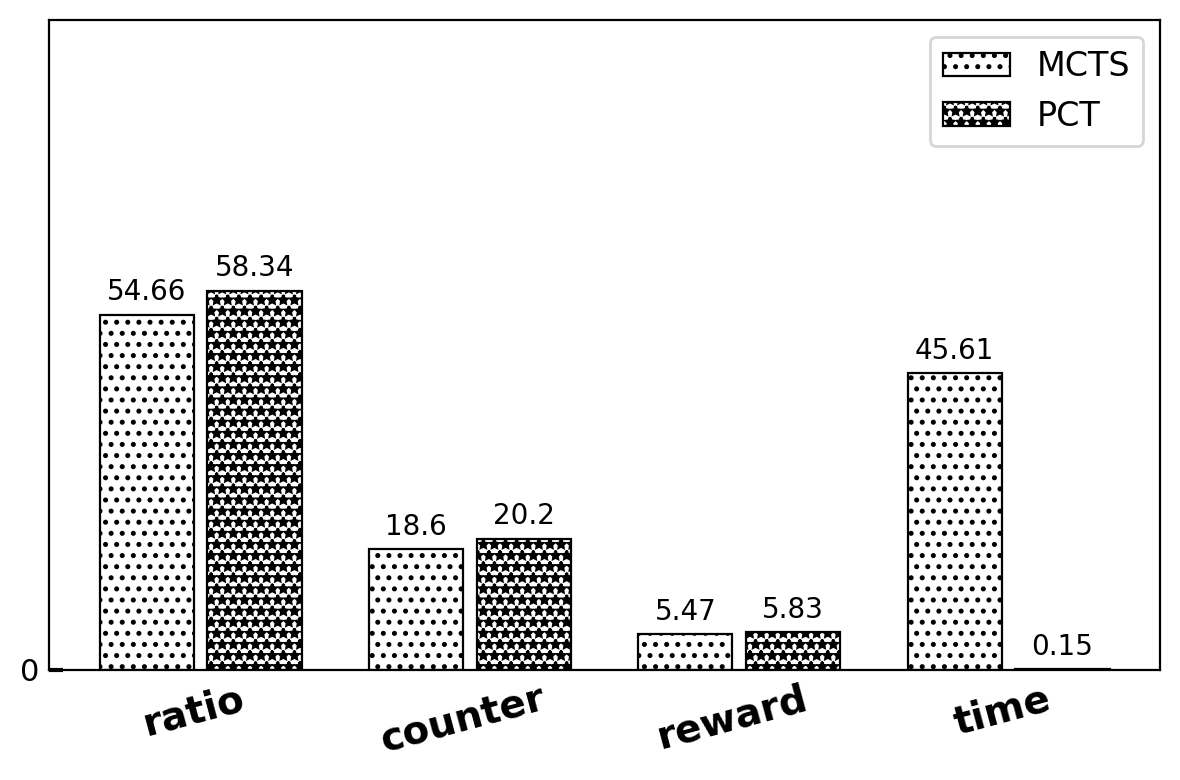

In [54]:
labels = ['ratio', 'counter', 'reward', 'time']
means_mcts = result['MCTS'].mean(axis=-2)
means_mcts[0]=float("%.2f" % (100 * means_mcts[0]))
means_mcts[1]=float("%.2f" % (means_mcts[1]))
means_mcts[2]=float("%.2f" % (means_mcts[2]))
means_mcts[3]=float("%.2f" % (means_mcts[3]))
means_pct = result['PCT'].mean(axis=-2)
means_pct[0]=float("%.2f" % (100 * means_pct[0]))
means_pct[1]=float("%.2f" % (means_pct[1]))
means_pct[2]=float("%.2f" % (means_pct[2]))
means_pct[3]=float("%.2f" % (means_pct[3]))
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = ['Times New Roman']
fig,ax = plt.subplots(1,1,figsize=(6,4),dpi=200)
labels = labels
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

label_font = {
    'weight':'bold',
    'size':14,
    'family':'simsun'
}

rects1 = ax.bar(x - width/2, means_mcts, width, label='MCTS',ec='k',color='white', lw=.8, hatch='...')
rects2 = ax.bar(x + width/2 + .05, means_pct, width, label='PCT',ec='k',color='white', lw=.8, hatch='***')

ax.tick_params(which='major',direction='in',length=5,width=1.5,labelsize=11,bottom=False)
ax.tick_params(axis='x',labelsize=11,bottom=False,labelrotation=15)
ax.set_xticks(x)
ax.set_ylim(ymin = 0,ymax = 100)
ax.set_yticks(np.arange(0,100,200))

ax.set_ylabel('',fontdict=label_font)
ax.set_xticklabels(labels,fontdict=label_font)
#ax.legend(markerscale=10,fontsize=12,prop=legend_font)
ax.legend(markerscale=10,fontsize=12)

# Add some text for labels, title and custom x-axis tick labels, etc.
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)
fig.tight_layout()

Text(0, 0.5, 'Temperature (K)')

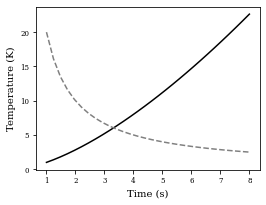

In [31]:
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)

x = np.linspace(1., 8., 30)
ax.plot(x, x ** 1.5, color='k', ls='solid')
ax.plot(x, 20/x, color='0.50', ls='dashed')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Temperature (K)')